# Korg for GALAH

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Korg and Julia
from juliacall import Main as jl
jl.seval("using Korg")
Korg = jl.Korg

# general packages
import time
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.io import readsav

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Prepare HERMES information
galah_lines = Korg.get_GALAH_DR3_linelist()

In [3]:
def rv_shift(rv_value, wavelength):
    return(wavelength / (1.+rv_value/299792.458))

In [4]:
def get_spectrum(sobject_id):
    
    spectrum = dict()
    spectrum['sobject_id'] = sobject_id
    
    for ccd in [1,2,3,4]:
        
        fits_file = fits.open('observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')
        spectrum['wave_air_ccd'+str(ccd)] = rv_shift(fits_file[0].header['RVCOM'], fits_file[0].header['CRVAL1'] + fits_file[0].header['CDELT1'] * np.arange(fits_file[0].header['NAXIS1']))
        spectrum['counts_ccd'+str(ccd)] = fits_file[0].data
        spectrum['counts_unc_ccd'+str(ccd)] = fits_file[0].data * fits_file[2].data
        spectrum['flux_norm_ccd'+str(ccd)] = fits_file[1].data
        spectrum['flux_unc_norm_ccd'+str(ccd)] = fits_file[1].data * fits_file[2].data
        
        fits_file.close()
        
    return(spectrum)

spectrum = get_spectrum(sobject_id = 210115002201239)

# ELEMENT ABUNDANCES

In [24]:
spectrum_waveobs = np.concatenate(([[Korg.air_to_vacuum(λ) for λ in spectrum['wave_air_ccd'+str(ccd)]] for ccd in [1,2,3,4]]))
spectrum_flux = np.concatenate(([[f for f in spectrum['flux_norm_ccd'+str(ccd)]] for ccd in [1,2,3,4]]))
spectrum_err = np.concatenate(([[f for f in spectrum['flux_unc_norm_ccd'+str(ccd)]] for ccd in [1,2,3,4]]))

In [25]:
spectrum_s = Table()

o_window = (spectrum_waveobs > 7770) & (spectrum_waveobs < 7780)

spectrum_s['waveobs'] = spectrum_waveobs#[o_window]
spectrum_s['flux'] = spectrum_flux#[o_window]
spectrum_s['err'] = spectrum_err#[o_window]
spectrum_s.write('Vesta_GALAH.csv',overwrite=True)

In [26]:
# synthesis_wls = jl.seval('7750:0.01:7800')
synthesis_wls = jl.seval('4700:0.01:7900')

LSF_matrix = Korg.compute_LSF_matrix(
    synthesis_wls,
    spectrum_s['waveobs'],
    28_000)

Constructing LSF matrix   3%|▉                           |  ETA:

In [ ]:
windows = dict()

# Oxygen
windows[8] = [(Korg.air_to_vacuum(7771.359),Korg.air_to_vacuum(7772.509)),(Korg.air_to_vacuum(7773.522),Korg.air_to_vacuum(7774.782)),(Korg.air_to_vacuum(7774.912),Korg.air_to_vacuum(7775.962))]

# Na
# windows[11] = [(Korg.air_to_vacuum(4751.689),Korg.air_to_vacuum(4751.944)),(Korg.air_to_vacuum(5682.517),Korg.air_to_vacuum(5682.997)),(Korg.air_to_vacuum(5687.917),Korg.air_to_vacuum(5688.392))]
windows[11] = [(Korg.air_to_vacuum(4751.4),Korg.air_to_vacuum(4752.2)),(Korg.air_to_vacuum(5682.3),Korg.air_to_vacuum(5683.3)),(Korg.air_to_vacuum(5687.3),Korg.air_to_vacuum(5688.7))]

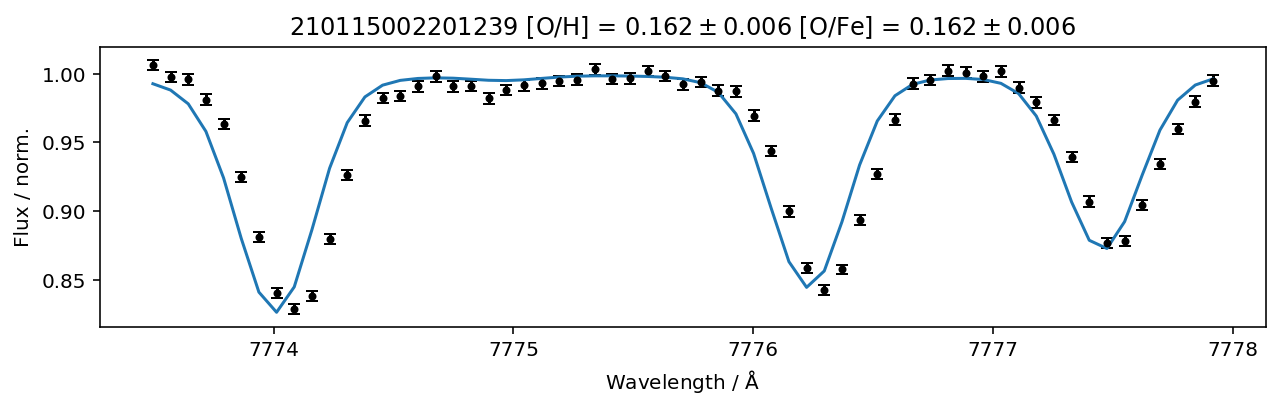

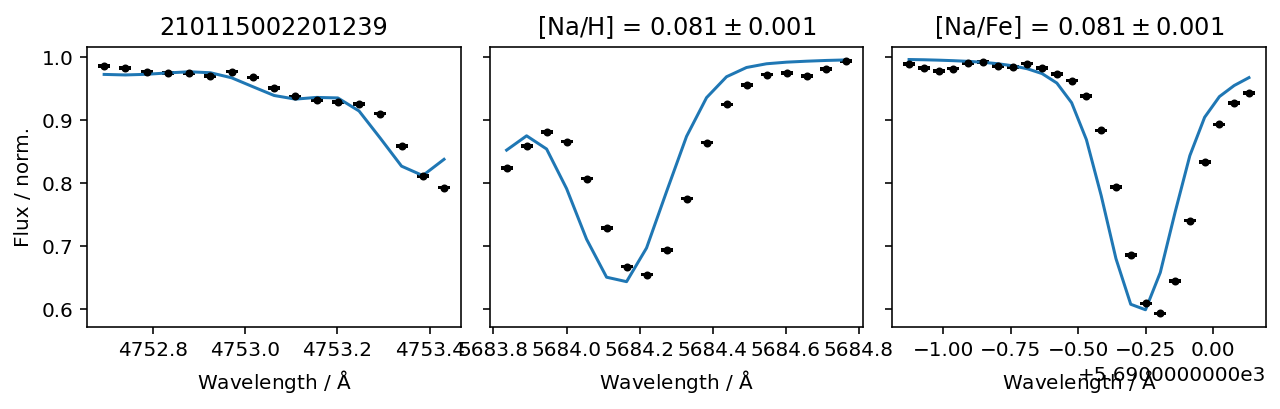

In [202]:
elements = ["O", "Na"]

for element in elements:

    params = {element:0.0, 'vsini':5.3}
    stellar_parameters = dict(Teff = 5772, logg = 4.44, m_H = 0.00, vmic = 1.06)

    fit_result = Korg.Fit.fit_spectrum(
        spectrum_s['waveobs'],
        spectrum_s['flux'],
        spectrum_s['err'],
        galah_lines, 
        params,
        stellar_parameters,
        windows=windows[Korg.atomic_numbers[element]],
        synthesis_wls=synthesis_wls, LSF_matrix=LSF_matrix
    )
    
    # Get pixels of observed and synthetic segments
    obs_wl_mask = np.array(fit_result.obs_wl_mask)
    mask_not_zero = np.where(obs_wl_mask[1:] > 0)[0]
    mask_begin = np.where(mask_not_zero[1:] - mask_not_zero[:-1] != 1)[0]
    if len(mask_begin) > 0:
        obs_pixels = [[mask_not_zero[0],mask_not_zero[mask_begin[0]]]]
        syn_pixels = [[0,mask_begin[0]]]
        for index in range(len(mask_begin)-1):
            obs_pixels.append([mask_not_zero[mask_begin[index]+1],mask_not_zero[mask_begin[index+1]]])
            syn_pixels.append([mask_begin[index]+1,mask_begin[index+1]])
        obs_pixels.append([mask_not_zero[mask_begin[index+1]+1],mask_not_zero[-1]])
        syn_pixels.append([mask_begin[index+1]+1,len(mask_not_zero)-1])
    else:
        obs_pixels = [[mask_not_zero[0],mask_not_zero[-1]]]
        syn_pixels = [[0,len(mask_not_zero)-1]]

    # Plot Results
    f, gs = plt.subplots(1,len(obs_pixels),figsize=(9,3),sharey=True)
    for panel in range(len(obs_pixels)):
        
        if len(obs_pixels) > 1:
            ax = gs[panel]
        else:
            ax = gs
        ax.errorbar(
            spectrum_s['waveobs'][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            spectrum_s['flux'][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            yerr = spectrum_s['err'][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            fmt = '.', c = 'k', capsize = 3
        )
        ax.plot(
            spectrum_s['waveobs'][obs_pixels[panel][0]:obs_pixels[panel][-1]],
            fit_result.best_fit_flux[syn_pixels[panel][0]:syn_pixels[panel][-1]]
        )

        parameter_result = fit_result.best_fit_params
        params_sigma = np.sqrt(np.diag(fit_result.covariance[1]))

        if panel == 0:
            if len(obs_pixels) > 1:
                ax.set_title(str(spectrum['sobject_id']))
            else:
                ax.set_title(str(spectrum['sobject_id'])+r' ['+element+'/H] = $'+"{:.3f}".format(parameter_result[element])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_result.covariance[0])==element)[0][0]])+'$'+r' ['+element+'/Fe] = $'+"{:.3f}".format(parameter_result[element] - stellar_parameters['m_H'])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_result.covariance[0])==element)[0][0]])+'$')
            ax.set_ylabel('Flux / norm.')
        if panel == 1:
            ax.set_title(r'['+element+'/H] = $'+"{:.3f}".format(parameter_result[element])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_result.covariance[0])==element)[0][0]])+'$')
        if panel == 2:
            ax.set_title(r'['+element+'/Fe] = $'+"{:.3f}".format(parameter_result[element] - stellar_parameters['m_H'])+' \pm '+"{:.3f}".format(params_sigma[np.where(np.array(fit_result.covariance[0])==element)[0][0]])+'$')
        ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
    plt.tight_layout()
    plt.show()
    plt.close()